In [1]:
import numpy as np
import pandas as pd
import random
import copy

from math import sqrt, log
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy.spatial
from haversine import haversine

import warnings
warnings.filterwarnings('ignore')

#### Download datasets

In [2]:
times = pd.read_csv(rf'./files/times v4.csv', sep=',')
lenght = pd.read_excel(rf'./files/terminal_data_hackathon v4.xlsx', sheet_name='TIDS')
income = pd.read_excel(rf'./files/terminal_data_hackathon v4.xlsx', sheet_name='Incomes')

income = income.set_index('TID')
lenght = lenght.set_index('TID')

random.seed(42)

In [3]:
distance_matrix = times.pivot_table(index = 'Origin_tid', columns = 'Destination_tid', values = 'Total_Time')
distance_matrix = distance_matrix.fillna(0)

# Visualisation

In [4]:
def get_divisors(number):
  result = {1, number}
  for divisor in range(2, number // 2  + 1):
    if number % divisor == 0:
        result.add(divisor)

  result = list(sorted(result))
  lenght_list = len(result)//2

  return result[lenght_list-1:lenght_list+1]

In [5]:
def separation_to_squares(df: pd.DataFrame, n_squares: int=4) -> dict:

    '''
        if n_squares is not power of 2, separetion will be separate for bigger different of metrics
    '''
    if n_squares < 0:
        print('Separation number is negative')
        return {}
    
    north = df.longitude.max()
    south = df.longitude.min()
    east = df.latitude.max()
    west = df.latitude.min()

    result = dict()

    '''
        search divisors for separetion of square
    '''
    if n_squares ** .5 == int(n_squares ** .5):
        multiplies = [int(sqrt(n_squares))-1]*2
    else:
        multiplies = get_divisors(n_squares)
        if multiplies[0] == 1:
            print('Primal number!')
            return result

    '''
        determine the position vaertical or horizontal
    '''
    if (north - south) > (east - west):
        position = 'vertical'
    else:
        position = 'horizontal'


    minimal = multiplies[0]+1
    maximal = multiplies[1]+1
    if multiplies[0] != multiplies[1]:
        if (n_squares != 0) and (n_squares & (n_squares-1) == 0):
                if position == 'vertical':
                    result['longitude'] = list(np.linspace(north, south, minimal))
                    result['latitude'] = list(np.linspace(east, west, maximal))
                else:
                    result['longitude'] = list(np.linspace(east, west, maximal))
                    result['latitude'] = list(np.linspace(north, south, minimal))
        else:
            if position == 'vertical':
                result['longitude'] = list(np.linspace(north, south, minimal))
                result['latitude'] = list(np.linspace(east, west, maximal))
            else:
                result['longitude'] = list(np.linspace(east, west, maximal))
                result['latitude'] = list(np.linspace(north, south, minimal))
    else:
        if position == 'vertical':
            result['longitude'] = list(np.linspace(north, south, minimal+1))
            result['latitude'] = list(np.linspace(east, west, maximal+1))
        else:
            result['longitude'] = list(np.linspace(east, west, maximal+1))
            result['latitude'] = list(np.linspace(north, south, minimal+1))

    result['longitude'] = result['longitude'][1:-1]
    result['latitude'] = result['latitude'][1:-1]
    result['side'] = {'north': north, 'south': south, 'east': east, 'west': west}

    return result


In [6]:
def visualisation_of_squares(df: pd.DataFrame, n_squares: int=4) -> dict:
    if n_squares < 0:
        print('Separation number is negative')
        return dict()
    multiplies = get_divisors(n_squares)
    if multiplies[0] == 1 and not (n_squares ** .5 == int(n_squares ** .5)):
        print('Primal number!')
        return dict()
    
    result = separation_to_squares(df, n_squares)

    fig, axes = plt.subplots(figsize=(12, 12))
    axes.scatter(data=df, x='latitude', y='longitude')

    for x in result['latitude']:
        axes.plot(np.array([x, x]), np.array([result['side']['south'], result['side']['north']]), color='red')

    for x in result['longitude']:
        axes.plot(np.array([result['side']['west'], result['side']['east']]), np.array([x, x]), color='red')
        
    axes.set_xlabel('latitude')
    axes.set_ylabel('longitude')

    return result

In [7]:
#visualisation_of_squares(lenght, 9)

#### Math model

In [8]:
model = copy.deepcopy(income)
RUB = 10**6
days = 14
month_day = 30
downtime = 10

In [9]:
tmp = list(income.columns)
model['sum'] = model[tmp].sum(axis=1)
model['mean'] = model[tmp].mean(axis=1)
model['std'] = model[tmp].std(axis=1)
model = model.drop(columns=tmp)

model['day'] = RUB/model['mean']
model['day_with_limit'] = np.where(model.day>=14, 14, model.day)
model['number_trips'] = month_day/model.day_with_limit
model['limit'] = model['day_with_limit'].round(0)
model['quantity'] = 1


model['test'] = model['number_trips'].round()

In [10]:
pivotmodel2 = model.groupby(by='limit')[['quantity']].sum().reset_index()
pivotmodel2['loop'] = pivotmodel2.quantity / pivotmodel2.limit.max()
pivotmodel2['case_loop'] = pivotmodel2.limit.max() / pivotmodel2.limit
pivotmodel2['category'] = np.where(pivotmodel2.loop > 5, 'b', 'a')

In [11]:
model = model.reset_index().merge(pivotmodel2[['limit', 'category']], on='limit', how='left')
model = model.set_index('TID')

#### K-Means Classtering

In [12]:
A_category = lenght.merge(model.query('category == "a"')[['test']], left_index=True, right_index=True, how='inner')
B_category = lenght.merge(model.query('category == "b"')[['test']], left_index=True, right_index=True, how='inner')
df = lenght.merge(model[['mean']], left_index=True, right_index=True, how='inner')

In [13]:
class Clastering():

    def __init__(self, df: pd.DataFrame, case: str, claster_limit: float, figsize: tuple=(5,3)):
        self.df = df
        self.case = case
        self.claster_limit = claster_limit
        self.__k = claster_limit+1
        self.figsize = figsize


    def distance(self, p1, p2):
        return haversine(p1[1:],p2[1:])
    

    def cluster_centroids(self, vals, clusters, k):
        results=[]
        for i in range(k):
            results.append(np.average(vals[clusters == i],weights=np.squeeze(np.asarray(vals[clusters == i][:,[0]])),axis=0))
        return results


    def kmeans(self, vals, k=None, centroids=None, steps=20):
        centroids = vals[np.random.choice(np.arange(len(vals)), k, False)]
        elbow = []
        for _ in range(max(steps, 1)):
            sqdists = scipy.spatial.distance.cdist(centroids, vals, lambda u, v: (self.distance(u,v)**2))
            elbow.append(sqdists)
            clusters = np.argmin(sqdists, axis=0)
            new_centroids = self.cluster_centroids(vals, clusters, k)
            if np.array_equal(new_centroids, centroids):
                break
            centroids = new_centroids
        
        return clusters, centroids, elbow


    def SSE(self) -> dict:
        vals = self.df[[self.case,'latitude','longitude']].values
        sse=[]
        data = {}
        try:
            for k in range(1,self.__k):
                clusters, centroids, elbow=self.kmeans(vals, k)
                sqdist = np.sum((elbow-np.mean(elbow))**2)
                sse.append(sqdist)
                data[k] = {'clusters': clusters, 'centroids': centroids, 'elbow': elbow}

            sse=sorted(sse,reverse=True)
            return {'sse': sse, 'data': data}
        except Exception:
            return self.SSE()

    def define_claster_limit(self, sse: list) -> list[int]:
        return [self.claster_limit, sse[self.claster_limit-1]]
        # for x in sse:
        #     if x <= self.claster_limit:
        #         c.append(sse.index(x)+1)
        #         c.append(x)
        #         return c

    
    def visualisation_claster(self) -> dict:
        df = self.SSE()
        sse = df['sse']
        fig = plt.figure(figsize=(5,3))
        c = self.define_claster_limit(sse)
        x=list(range(1,self.__k))
        labels=x
        plt.plot(x,sse,'r')
        plt.scatter(x,sse,marker='x')
        plt.xticks(x, labels)
        plt.title('Elbow Method')
        plt.xlabel('K')
        plt.ylabel('SSE Distance')
        plt.plot([c[0], c[0]], [0, c[1]], color='green', linestyle='dashed', linewidth=2)  # plotting the arbitrary line from point (25,10) to (65,45).    
        plt.show()
        df['clester_count'] = c[0]
        return df


    def selections(self):
        scce = self.visualisation_claster()
        data = scce['data'][scce['clester_count']]

        self.df['c']=[int(c) for c in data['clusters']]

        lats = [data['centroids'][i][1] for i in range(scce['clester_count'])]
        self.df['clat'] = self.df['c'].map(lambda x: lats[x])

        longs = [data['centroids'][i][2] for i in range(scce['clester_count'])]
        self.df['clong'] = self.df['c'].map(lambda x: longs[x])

        return self.df, scce
    

    @staticmethod
    def plot_clasters(df, k):
        c_lat=list(set(df['clat']))
        c_long=list(set(df['clong']))

        fig, ax = plt.subplots(figsize=(10, 6))
        colors = ['gold', 'cornflowerblue', 'limegreen', 'violet', 'pink', 
                  'brown', 'salmon', 'aqua', 'olive', 'chocolate',
                  'indigo', 'orchid', 'silver', 'peru', 'navu']
        for x in range(k):
            x1=df.query(f'c=={x}')['latitude'].values.tolist()
            y1=df.query(f'c=={x}')['longitude'].values.tolist()
            plt.scatter(y1,x1, color=colors[x])
        plt.scatter(c_long,c_lat,marker='x', color='black')
        plt.show()
        

In [14]:
A_category = Clastering(A_category, 'test', 14)
B_category = Clastering(B_category, 'test', 14)
df = Clastering(df, 'number_trips', 14)

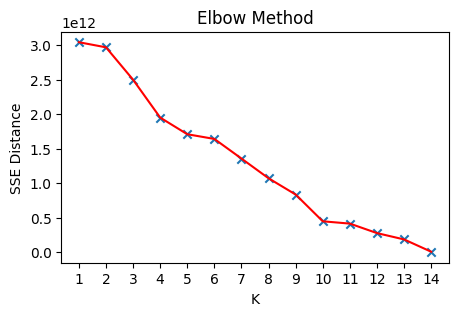

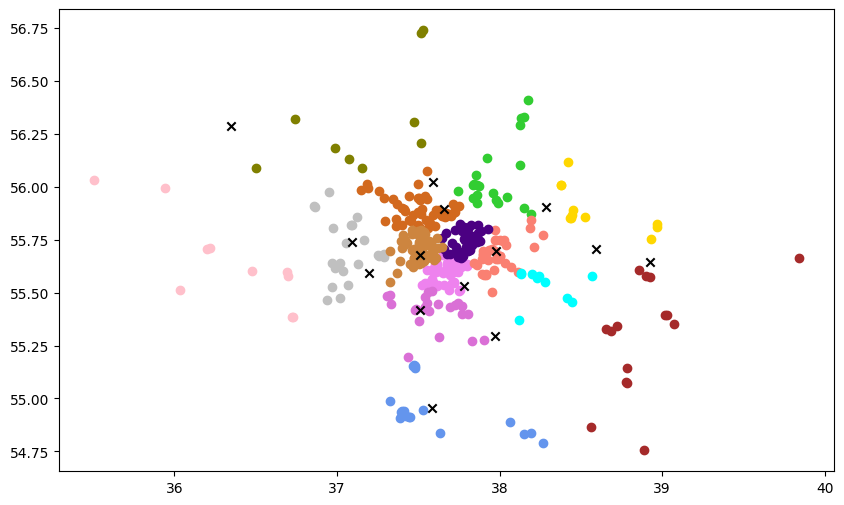

In [15]:
A_category, scce = A_category.selections()
Clastering.plot_clasters(A_category, scce['clester_count'])

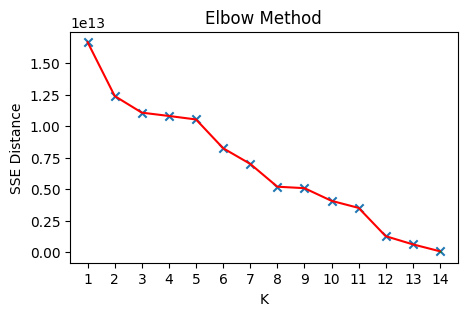

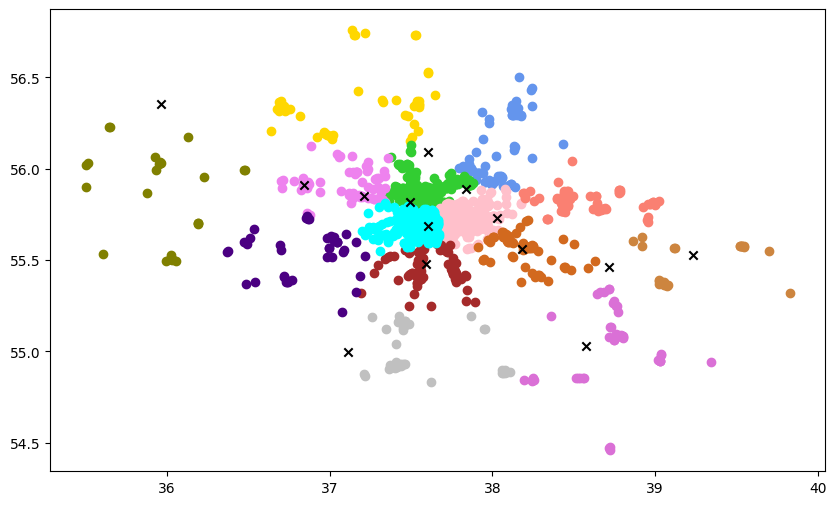

In [16]:
B_category, scce = B_category.selections()
Clastering.plot_clasters(B_category, scce['clester_count'])

#### K-Means Classtering (added)

In [17]:
A_category = A_category.reset_index()
B_category = B_category.reset_index()
model_added = copy.deepcopy(model)


def float_to_int(base: int, x: float) -> int:
    x = str(x).split('.')
    return int(x[0])*base + int(x[1])

In [18]:
A_claster = times.merge(A_category[['TID', 'c']], left_on='Origin_tid', right_on='TID', how='left')
A_claster = A_claster.merge(A_category[['TID', 'c']], left_on='Destination_tid', right_on='TID', how='left')

B_claster = times.merge(B_category[['TID', 'c']], left_on='Origin_tid', right_on='TID', how='left')
B_claster = B_claster.merge(B_category[['TID', 'c']], left_on='Destination_tid', right_on='TID', how='left')

In [19]:
A_claster = A_claster.query('c_x==c_y').drop(columns=['TID_x', 'TID_y', 'c_y']).rename(columns={'c_x': 'cluster'})
B_claster = B_claster.query('c_x==c_y').drop(columns=['TID_x', 'TID_y', 'c_y']).rename(columns={'c_x': 'cluster'})


In [20]:

l = pd.DataFrame({
      'Mean Time': A_claster.query(f'cluster=={x}').Total_Time.mean(), 
      'Number of points': A_claster.query(f'cluster=={x}').drop_duplicates(subset='Origin_tid', keep='first').shape[0],
      'Time %': (A_claster.query(f'cluster=={x}').drop_duplicates(subset='Origin_tid', keep='first').shape[0]/model.shape[0]) * A_claster.query(f'cluster=={x}').Total_Time.mean(),
      'Number of cluster': x} for x in range(scce['clester_count']))
print(l['Mean Time'].mean())
print(l['Number of points'].sum())
print(l['Number of points'].mean())
l['Total time A'] = l['Mean Time'] * l['Number of points']
l['Total time A / 720'] = l['Total time A'] / 720
print(l['Total time A'].mean())
print(l['Total time A / 720'].mean())
print()
print(l)

35.66736386574945
377
26.928571428571427
740.3286066510818
1.0282341759042806

    Mean Time  Number of points    Time %  Number of cluster  Total time A  \
0   39.244636                11  0.264841                  0    431.691000   
1   39.194935                18  0.432827                  1    705.508824   
2   38.400690                21  0.494733                  2    806.414500   
3   15.986456                43  0.421729                  3    687.417619   
4   63.736556                10  0.391022                  4    637.365556   
5   63.302571                15  0.582539                  5    949.538571   
6   27.628990                38  0.644111                  6   1049.901622   
7   28.347444                10  0.173911                  7    283.474444   
8   69.190417                 9  0.382033                  8    622.713750   
9   21.882941                51  0.684681                  9   1116.030000   
10  14.747623                47  0.425238                 10   

In [21]:
l = pd.DataFrame({
      'Mean Time': B_claster.query(f'cluster=={x}').Total_Time.mean(), 
      'Number of points': B_claster.query(f'cluster=={x}').drop_duplicates(subset='Origin_tid', keep='first').shape[0],
      'Time %': (B_claster.query(f'cluster=={x}').drop_duplicates(subset='Origin_tid', keep='first').shape[0]/model.shape[0]) * B_claster.query(f'cluster=={x}').Total_Time.mean(),
      'Number of cluster': x} for x in range(scce['clester_count']))

print(l['Mean Time'].mean())
print(l['Number of points'].sum())
print(l['Number of points'].mean())
l['Total time B'] = l['Mean Time'] * l['Number of points']
l['Total time B / 720'] = l['Total time B'] / 720
print(l['Total time B'].mean())
print(l['Total time B / 720'].mean())
print()
print(l)

36.1870453842548
1253
89.5
2664.227185863412
3.7003155359214053

    Mean Time  Number of points    Time %  Number of cluster  Total time B  \
0   52.802127                52  1.684485                  0   2745.710588   
1   40.482251                78  1.937187                  1   3157.615584   
2   21.930787               214  2.879257                  2   4693.188357   
3   36.149556                72  1.596790                  3   2602.768028   
4   21.587105               245  3.244688                  4   5288.840820   
5   26.192871                88  1.414094                  5   2304.972644   
6   31.251556                85  1.629682                  6   2656.382262   
7   19.935385               165  2.017999                  7   3289.338476   
8   54.734696                28  0.940228                  8   1532.571481   
9   31.511459                66  1.275924                  9   2079.756308   
10  39.791905                42  1.025313                 10   1671.260000   

In [22]:
A_model = model_added.merge(A_claster.drop_duplicates(subset='Origin_tid', keep='first').set_index('Origin_tid')[['Total_Time', 'cluster']], left_index=True, right_index=True, how='inner')
B_model = model_added.merge(B_claster.drop_duplicates(subset='Origin_tid', keep='first').set_index('Origin_tid')[['Total_Time', 'cluster']], left_index=True, right_index=True, how='inner')

In [23]:
A_model['downtime'] = downtime * 60
A_model['Total_Time'] = A_model['Total_Time'].apply(lambda x: float_to_int(100, x))
A_model['Common_Time'] = A_model[['Total_Time', 'downtime']].sum(axis=1)
A_model['Car_per_minute'] = 20000/(12*60)
A_model['Maintenance_cost_one_time'] = A_model['Common_Time']/60 * A_model['Car_per_minute']
A_model['Maintenance_cost_per_month'] = A_model['number_trips'] * A_model['Maintenance_cost_one_time']
A_model['Car_time'] = A_model['number_trips'] * A_model['Common_Time']/60
((A_model.Car_time.sum() / month_day) / (12*60)) * 20000 * 30

1664704.2413949275

In [24]:
B_model['downtime'] = downtime * 60
B_model['Total_Time'] = B_model['Total_Time'].apply(lambda x: float_to_int(100, x))
B_model['Common_Time'] = B_model[['Total_Time', 'downtime']].sum(axis=1)
B_model['Car_per_minute'] = 20000/(12*60)
B_model['Maintenance_cost_one_time'] = B_model['Common_Time']/60 * B_model['Car_per_minute']
B_model['Maintenance_cost_per_month'] = B_model['number_trips'] * B_model['Maintenance_cost_one_time']
B_model['Car_time'] = B_model['number_trips'] * B_model['Common_Time']/60
((B_model.Car_time.sum() / month_day) / (12*60)) * 20000 * 30

3141467.7624439267

In [25]:
B_claster.drop_duplicates(subset='Origin_tid', keep='first')

,Origin_tid,Destination_tid,Total_Time,cluster
83,607066,680312,30.49,12.0
747,609468,695030,4.76,4.0
825,629520,695030,4.79,4.0
903,698682,695030,5.16,4.0
1004,635206,635287,50.95,1.0
...,...,...,...,...
766659,645381,622486,26.56,5.0
843363,606554,606556,1.63,11.0
860214,606578,662968,29.51,11.0
1324620,635569,679673,74.88,13.0


### Reesrt of routes

In [26]:
income.columns = pd.to_datetime(income.columns).date
B_income = B_claster.drop_duplicates(subset='Origin_tid', keep='first').rename(columns={'Origin_tid': 'TID'}).set_index('TID')[['cluster']].merge(
    income, left_index=True, right_index=True, how='left'
)
start = B_income.columns[1]

In [27]:
residue = B_income[[start]].reset_index()
residue['Date'] = start
residue['Number_day'] = 0
residue = residue.rename(columns={'TID': 'Id', start: 'Balance_close'})
reestr = pd.DataFrame([], columns=['Id', 'Balance_open', 'Income', 'Outcome', 'Balance_close', 'Date', 'Number_day'])
reestr = pd.concat([reestr, residue]).fillna(0)

In [28]:
# if True:
#     c = 0

#     for x in list(B_income.columns)[2:32]:
#         counter = B_income.shape[0]/7
#         nextday = B_income[[x]]
#         nextday = nextday.reset_index()
#         nextday['Date'] = x
#         nextday = nextday.rename(columns={'TID': 'Id', x: 'Income'})

#         for y in list(nextday.Id):
            
#             signal = int(c%14)
#             c += 1

#             reestr_tmp = reestr.query(f'Id=={y}').tail(1)
#             nextday_tmp = nextday.query(f'Id=={y}')

#             nextday_tmp['Balance_open'] = reestr_tmp.Balance_close.values[0]

#             #(nextday_tmp.Number_day >= 14) | 

#             nextday_tmp['Number_day'] = reestr_tmp.Number_day.values[0]+1
#             nextday_tmp['Outcome'] = np.where((nextday_tmp.Balance_open >= 10**6) | 
#                                               (nextday_tmp.Number_day == signal), nextday_tmp.Balance_open, 0)

            

#             nextday_tmp['Number_day'] = np.where((nextday_tmp.Number_day.values[0] >= 14) | (nextday_tmp.Outcome !=0), 1, nextday_tmp.Number_day)
#             nextday_tmp['Balance_close'] = nextday_tmp.Balance_open + nextday_tmp.Income - nextday_tmp.Outcome

#             reestr = pd.concat([reestr, nextday_tmp]).fillna(0)

#         for y in list(reestr.query('Date == @x and Outcome == 0').sort_values(by='Balance_open', ascending=False).Id):
#             if reestr.query(f'Date == @x and Outcome != 0').shape[0] >= counter:
#                 break

#             reestr_tmp = reestr.query(f'Id=={y}').tail(1)
#             nextday_tmp = nextday.query(f'Id=={y}')

#             nextday_tmp['Balance_open'] = reestr_tmp.Balance_close.values[0]

#             nextday_tmp['Outcome'] = np.where(True, nextday_tmp.Balance_open, 0)

#             nextday_tmp['Number_day'] = 1
#             nextday_tmp['Balance_close'] = nextday_tmp.Balance_open + nextday_tmp.Income - nextday_tmp.Outcome

#             reestr = pd.concat([reestr, nextday_tmp]).fillna(0)

#     reestr.to_excel(rf'./files/B_reestr_log_std.xlsx', index=False)

In [29]:
# pivot = pd.read_excel(rf'./files/B_reestr_log_std.xlsx')
# pivot['signal'] = np.where(pivot.Outcome != 0, 1, np.nan)
# pivot = pivot.pivot_table(index='Date', values='signal', aggfunc='sum')
# pivot.to_excel(rf'./files/B_pivotr_log_std.xlsx')
# pivot

# Маршрутизация

In [30]:
def build_routes(df, max_time):
    points = list(df.columns)
    routes = []
    while points:
        current_time = 0
        route = [points.pop(0)]
        while points:
            # вычисление времени до следующей точки
            next_point = min(points, key=lambda point: df.loc[route[-1], point])
            next_time = df.loc[route[-1], next_point] + 10
            
            # если добавление следующей точки приведет к превышению максимального времени, 
            # завершим текущий маршрут и начнем новый
            if current_time + next_time > max_time:
                #print(current_time + next_time)
                break
            
            route.append(next_point)
            points.remove(next_point)
            current_time += next_time

        routes.append(route)

    return routes

def routes_from_arr_points(category, distance_matrix):
    center = (category['longitude'].mean(), category['latitude'].mean())
    category['distance_to_center'] = np.sqrt((category['longitude'] - center[0]) ** 2 + (category['latitude'] - center[1]) ** 2)
    closest_point_index  = category.loc[[category['distance_to_center'].idxmin()]].to_dict('records')
    
    first_point = closest_point_index[0]['TID']

    set_points = list(set(category['TID']))
    set_points.pop(set_points.index(first_point))
    set_points.insert(0, first_point)
    
    
    df_distance = distance_matrix.loc[set_points, set_points]
    routes = build_routes(df_distance, 2600*0.565)
    count = 1
    for route in routes:
        print(len(route))
        df_ = distance_matrix.loc[route, route]
        
        route = pd.DataFrame({'First': route[:-1], 'Second': route[1:]})
        route = route.merge(times, left_on=['First', 'Second'], right_on=['Origin_tid','Destination_tid'])
        route = route.merge(lenght, left_on=['First'], right_on=['TID'])
        route = route.rename(columns = {'longitude':'longitude1', 'latitude':'latitude1'})
        route['Total_Time'] = route['Total_Time'] + 10

        route = route.merge(lenght, left_on=['Second'], right_on=['TID'])
        route = route.rename(columns = {'longitude':'longitude2', 'latitude':'latitude2'})

        route = route.drop(columns = ['Origin_tid', 'Destination_tid'])

        route['Idle'] = 10
        route['Delivery'] = route['Total_Time']-10
        route = route[['First', 'Second', 'longitude1', 'latitude1', 'longitude2', 'latitude2', 'Total_Time', 'Idle', 'Delivery']]
        route.to_excel(rf'./routes/route_number_{count}.xlsx', index=False)
        count += 1

In [31]:
routes_from_arr_points(B_category, distance_matrix)

111
114
109
103
99
110
72
89
86
88
88
82
66
36
